In [7]:
import shutil

shutil.copy(
    "/kaggle/input/dermalscan/dermalscan_pipeline.py",
    "/kaggle/working/dermalscan_pipeline.py"
)


'/kaggle/working/dermalscan_pipeline.py'

In [4]:
import sys
sys.path.append("/kaggle/working")


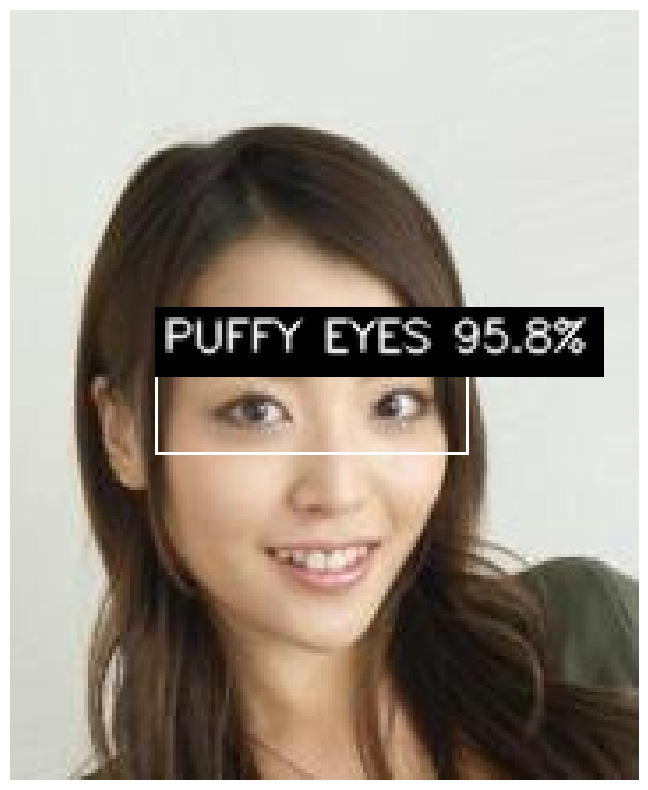

In [21]:
import cv2
import numpy as np
from tensorflow.keras.models import load_model
from tensorflow.keras.applications.efficientnet import preprocess_input
import matplotlib.pyplot as plt

MODEL_PATH = "/kaggle/input/module-4-1/module_4/model/dermalscan_efficientnet_model.h5"
CASCADE_PATH = "/kaggle/input/module-4-1/module_4/haarcascade/haarcascade_frontalface_default.xml"
IMAGE_PATH = "/kaggle/input/module-4-1/module_4/test_images/008251.jpg"

class DermalScanner:
    def __init__(self, model_path, cascade_path):
        self.model = load_model(model_path)
        self.face_cascade = cv2.CascadeClassifier(cascade_path)
        self.class_names = ["wrinkles", "dark spots", "puffy eyes", "clear skin"]

    def classic_draw(self, img, text, rect, color=(255, 255, 255)):
 
        x, y, w, h = rect
        cv2.rectangle(img, (x, y), (x + w, y + h), color, 1) # Thickness 1
        
        font = cv2.FONT_HERSHEY_SIMPLEX
        scale = 0.4
        thickness = 1
        (t_w, t_h), _ = cv2.getTextSize(text, font, scale, thickness)
        
        # Black background for text readability
        cv2.rectangle(img, (x, y - t_h - 10), (x + t_w + 5, y), (0, 0, 0), -1)
        cv2.putText(img, text, (x + 2, y - 7), font, scale, color, thickness, cv2.LINE_AA)

    def get_prediction(self, roi):
        if roi is None or roi.size == 0: return 0, 0, 0, 0
        img_input = cv2.resize(roi, (224, 224))
        img_input = np.expand_dims(img_input, axis=0)
        img_input = preprocess_input(img_input.astype(np.float32))
        preds = self.model.predict(img_input, verbose=0)[0]
        return preds # Returns [wrinkles, dark_spots, puffy_eyes, clear_skin]

    def detect(self, image_path):
        img = cv2.imread(image_path)
        if img is None: return None
        output = img.copy()
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        
        faces = self.face_cascade.detectMultiScale(gray, 1.1, 4, minSize=(100, 100))

        if len(faces) == 0:
            # Fallback: assume the whole image is the face if detector fails
            faces = [(0, 0, img.shape[1], img.shape[0])]

        for (x, y, w, h) in faces:
            face_img = img[y:y+h, x:x+w]
            # 1. Forehead (top 25% of face)
            forehead_zone = face_img[int(0.05*h):int(0.3*h), int(0.2*w):int(0.8*w)]
            # 2. Eye Region (middle section)
            eye_zone = face_img[int(0.3*h):int(0.5*h), int(0.1*w):int(0.9*w)]
            # 3. Lower Face/Cheeks (bottom section)
            lower_zone = face_img[int(0.5*h):int(0.9*h), int(0.15*w):int(0.85*w)]

            f_preds = self.get_prediction(forehead_zone)
            e_preds = self.get_prediction(eye_zone)
            l_preds = self.get_prediction(lower_zone)

            wrinkle_score = f_preds[0] * 100
            puffy_score = e_preds[2] * 100
            spot_score = l_preds[1] * 100

            total_deduction = 0
            if wrinkle_score > 70: total_deduction += (wrinkle_score * 0.3)
            if puffy_score > 70: total_deduction += (puffy_score * 0.3)
            if spot_score > 70: total_deduction += (spot_score * 0.3)
            
            clear_skin_score = max(0, 100 - total_deduction)
            active_boxes = 0

            if wrinkle_score > 75:
                self.classic_draw(output, f"WRINKLES {wrinkle_score:.1f}%", 
                                 (x+int(0.2*w), y+int(0.05*h), int(0.6*w), int(0.25*h)))
                active_boxes += 1

            if puffy_score > 75:
                self.classic_draw(output, f"PUFFY EYES {puffy_score:.1f}%", 
                                 (x+int(0.1*w), y+int(0.3*h), int(0.8*w), int(0.2*h)))
                active_boxes += 1

            if spot_score > 75:
                self.classic_draw(output, f"DARK SPOTS {spot_score:.1f}%", 
                                 (x+int(0.15*w), y+int(0.5*h), int(0.7*w), int(0.4*h)))
                active_boxes += 1

            if active_boxes == 0 or clear_skin_score > 85:
                if active_boxes == 0: 
                    self.classic_draw(output, f"CLEAR SKIN {clear_skin_score:.1f}%", (x, y, w, h), (180, 255, 180))

        return output

scanner = DermalScanner(MODEL_PATH, CASCADE_PATH)
final_view = scanner.detect(IMAGE_PATH)

if final_view is not None:
    plt.figure(figsize=(10, 10))
    plt.imshow(cv2.cvtColor(final_view, cv2.COLOR_BGR2RGB))
    plt.axis('off')
    plt.show()

AGE : 21-24
WRINKLES  : 0.73%
PUFFY EYES: 99.74%
DARK SPOTS: 3.26%
CLEAR SKIN: 70.08%


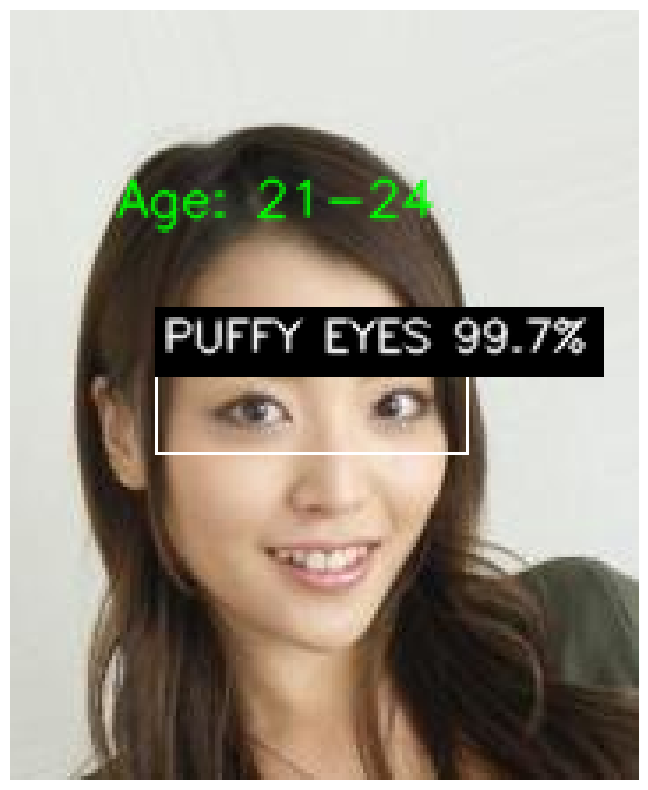

In [2]:
import cv2
import numpy as np
from tensorflow.keras.models import load_model
from tensorflow.keras.applications.efficientnet import preprocess_input
import matplotlib.pyplot as plt
MODEL_PATH = "/kaggle/input/dermalscan-efficientnet1/keras/default/1/DermalScan_EfficientNet.h5"
CASCADE_PATH = "/kaggle/input/module-4-1/module_4/haarcascade/haarcascade_frontalface_default.xml"
IMAGE_PATH = "//kaggle/input/module-4-1/module_4/test_images/008251.jpg"
AGE_PROTO = "/kaggle/input/opencv-files/age_deploy.prototxt"
AGE_MODEL = "/kaggle/input/opencv-files/age_net.caffemodel"
AGE_BUCKETS = ["0-2","4-6","8-12","15-20","21-24","25-32","33-40","41-50","51-60","60+"]

class DermalScanner:
    def __init__(self, model_path, cascade_path):
        self.model = load_model(model_path)
        self.face_cascade = cv2.CascadeClassifier(cascade_path)
        self.class_names = ["wrinkles", "dark_spots", "puffy_eyes", "clear_skin"]
        self.age_net = cv2.dnn.readNetFromCaffe(AGE_PROTO, AGE_MODEL)


    def estimate_age(self, face):
        blob = cv2.dnn.blobFromImage(face,1.0,(227,227),(78.426,87.768,114.896))
        self.age_net.setInput(blob)
        pred = self.age_net.forward()
        idx = np.argmax(pred)
        return AGE_BUCKETS[idx]


    def classic_draw(self, img, text, rect, color=(255, 255, 255)):
        x, y, w, h = rect
        cv2.rectangle(img, (x, y), (x + w, y + h), color, 1)

        font = cv2.FONT_HERSHEY_SIMPLEX
        scale = 0.4
        thickness = 1
        (t_w, t_h), _ = cv2.getTextSize(text, font, scale, thickness)

        cv2.rectangle(img, (x, y - t_h - 10), (x + t_w + 5, y), (0, 0, 0), -1)
        cv2.putText(img, text, (x + 2, y - 7), font, scale, color, thickness, cv2.LINE_AA)


    def get_prediction(self, roi):
        if roi is None or roi.size == 0: return 0, 0, 0, 0
        img_input = cv2.resize(roi, (224, 224))
        img_input = np.expand_dims(img_input, axis=0)
        img_input = preprocess_input(img_input.astype(np.float32))
        preds = self.model.predict(img_input, verbose=0)[0]
        return preds


    def detect(self, image_path):
        img = cv2.imread(image_path)
        if img is None: return None
        output = img.copy()
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        
        faces = self.face_cascade.detectMultiScale(gray, 1.1, 4, minSize=(100, 100))

        if len(faces) == 0:
            faces = [(0, 0, img.shape[1], img.shape[0])]

        for (x, y, w, h) in faces:
            face_img = img[y:y+h, x:x+w]

            age = self.estimate_age(face_img)

            cv2.putText(
                output,
                f"Age: {age}",
                (x, y - 12 if y > 20 else y + h + 18),
                cv2.FONT_HERSHEY_SIMPLEX,
                0.48,
                (0,255,0),
                1,
                cv2.LINE_AA
            )

            forehead_zone = face_img[int(0.05*h):int(0.3*h), int(0.2*w):int(0.8*w)]
            eye_zone = face_img[int(0.3*h):int(0.5*h), int(0.1*w):int(0.9*w)]
            lower_zone = face_img[int(0.5*h):int(0.9*h), int(0.15*w):int(0.85*w)]

            f_preds = self.get_prediction(forehead_zone)
            e_preds = self.get_prediction(eye_zone)
            l_preds = self.get_prediction(lower_zone)

            wrinkle_score = f_preds[0] * 100
            puffy_score = e_preds[2] * 100
            spot_score = l_preds[1] * 100

            total_deduction = 0
            if wrinkle_score > 70: total_deduction += (wrinkle_score * 0.3)
            if puffy_score > 70: total_deduction += (puffy_score * 0.3)
            if spot_score > 70: total_deduction += (spot_score * 0.3)

            clear_skin_score = max(0, 100 - total_deduction)
            print("AGE :", age)
            print(f"WRINKLES  : {wrinkle_score:.2f}%")
            print(f"PUFFY EYES: {puffy_score:.2f}%")
            print(f"DARK SPOTS: {spot_score:.2f}%")
            print(f"CLEAR SKIN: {clear_skin_score:.2f}%")

            active_boxes = 0

            if wrinkle_score > 75:
                self.classic_draw(output, f"WRINKLES {wrinkle_score:.1f}%", 
                    (x+int(0.2*w), y+int(0.05*h), int(0.6*w), int(0.25*h)))
                active_boxes += 1

            if puffy_score > 75:
                self.classic_draw(output, f"PUFFY EYES {puffy_score:.1f}%", 
                    (x+int(0.1*w), y+int(0.3*h), int(0.8*w), int(0.2*h)))
                active_boxes += 1

            if spot_score > 75:
                self.classic_draw(output, f"DARK SPOTS {spot_score:.1f}%", 
                    (x+int(0.15*w), y+int(0.5*h), int(0.7*w), int(0.4*h)))
                active_boxes += 1

            if active_boxes == 0 or clear_skin_score > 85:
                if active_boxes == 0:
                    self.classic_draw(output, f"CLEAR SKIN {clear_skin_score:.1f}%", (x, y, w, h), (180, 255, 180))

        return output


scanner = DermalScanner(MODEL_PATH, CASCADE_PATH)
final_view = scanner.detect(IMAGE_PATH)

if final_view is not None:
    plt.figure(figsize=(10, 10))
    plt.imshow(cv2.cvtColor(final_view, cv2.COLOR_BGR2RGB))
    plt.axis('off')
    plt.show()


In [3]:
!wget -q https://raw.githubusercontent.com/spmallick/learnopencv/master/AgeGender/AgeNet/age_deploy.prototxt
!wget -q https://github.com/spmallick/learnopencv/raw/master/AgeGender/AgeNet/age_net.caffemodel

print("Downloaded Successfully")

AGE_PROTO = "/kaggle/working/age_deploy.prototxt"
AGE_MODEL = "/kaggle/working/age_net.caffemodel"

print("AGE_PROTO:", AGE_PROTO)
print("AGE_MODEL:", AGE_MODEL)


Downloaded Successfully
AGE_PROTO: /kaggle/working/age_deploy.prototxt
AGE_MODEL: /kaggle/working/age_net.caffemodel


In [37]:
import os
print(os.getcwd())


/kaggle/working


In [38]:
import os
os.listdir("/kaggle/working")


['module4_output.jpg',
 '.virtual_documents',
 '__pycache__',
 'dermalscan_pipeline.py']

In [40]:
!find / -name "age_deploy.prototxt" 2>/dev/null


In [42]:
!ls -lh
!find / -name "age_deploy.prototxt"


total 24K
-rw-r--r-- 1 root root 3.4K Dec 25 14:05 dermalscan_pipeline.py
-rw-r--r-- 1 root root  16K Dec 25 14:06 module4_output.jpg
drwxr-xr-x 2 root root 4.0K Dec 25 14:06 __pycache__
